In [30]:
from sk_dsp_comm import digitalcom as dc
import pandas as pd
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt
import commpy
import seaborn as sns
import scipy
from PIL import Image
from scipy import ndimage
from scipy import misc
from dec2bin import *
import math
import matplotlib.image as mpimg



<function matplotlib.pyplot.show(*args, **kw)>

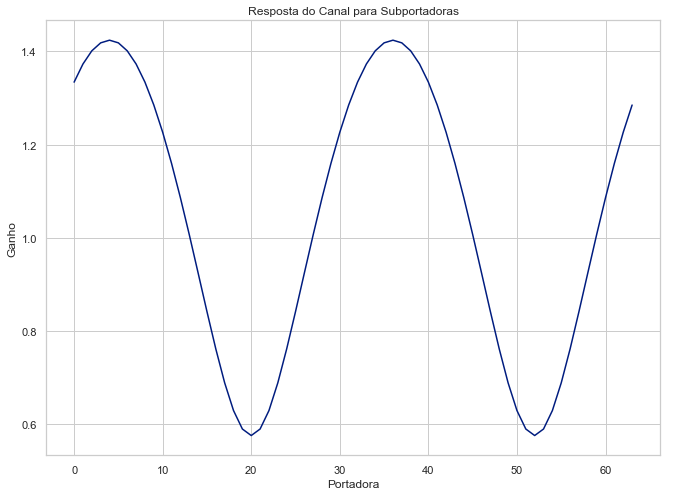

In [31]:
############# Creating Channel Response #####################

K = 64
allCarriers = np.arange(K)
sns.set(style="whitegrid", palette="dark", color_codes=True)
graph_dims = (11.0, 8.0)
fig, plot = plt.subplots(figsize=graph_dims)
channelResp = np.array([1, 0, 0.3+0.3j]) 
H_exact = np.fft.fft(channelResp, K)
plt.plot(allCarriers, abs(H_exact))
plt.title('Resposta do Canal para Subportadoras')
plt.xlabel('Portadora')
plt.ylabel('Ganho')
plt.grid(True)
plt.show

In [32]:
################# Creating Mapping for Modulations ##############

mod_bpsk= commpy.modulation.PSKModem(2)
mod_qpsk= commpy.modulation.QAMModem(4)
mod_16qam= commpy.modulation.QAMModem(16)
mod_64qam= commpy.modulation.QAMModem(64)
mod_256qam = commpy.modulation.QAMModem(256)

def mod_param(modtype):
    
    modscheme = {
        'bpsk':{'mu':1,'map': mod_bpsk},
        'qpsk':{'mu':2,'map': mod_qpsk},
        '16qam':{'mu':4,'map': mod_16qam},
        '64qam':{'mu':6,'map': mod_64qam},
        '256qam':{'mu':8,'map': mod_256qam},
    }
    
    mu = modscheme[modtype]['mu']
    mapping_table = modscheme[modtype]['map']
    
    return mu,mapping_table

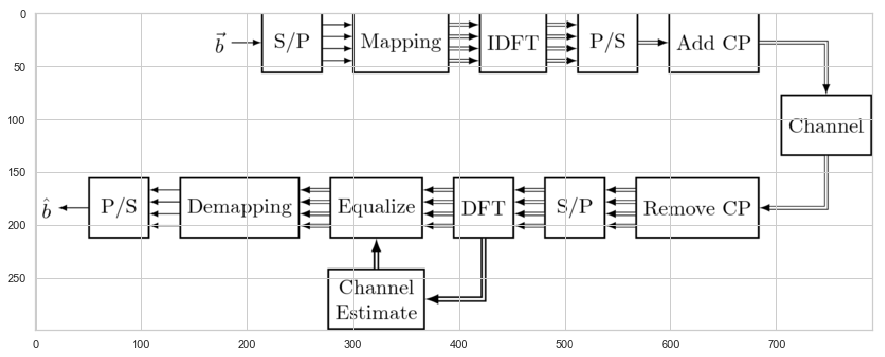

In [33]:
################### Esquema de Modulacao OFDM ##############

ofdm_modulator_schema =   Image.open('ofdm_full_modulator_scheme.png')
im_ofdm_arr = np.array(ofdm_modulator_schema)

sns.set(style="whitegrid", palette="dark", color_codes=True)
graph_dims = (15.0, 8.7)
fig, plot = plt.subplots(figsize=graph_dims)
imgplot = plt.imshow(im_ofdm_arr)
plt.show()

In [34]:
########################### Elements in OFMD Scheme #######################


### Series/Parallel Passage and Mapping #####

def SP_Mapping(bits,modulator): 
    
        return modulator.modulate(bits)
    
    
# Allocation of different subcarriers with data and pilots    
    
def OFDM_symbol(MOD_payload,pilotCarriers,dataCarriers,pilotValue):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
    symbol[dataCarriers] = MOD_payload  # allocate the pilot subcarriers
    return symbol

### IDFT 

def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)

#### Add CP

def addCP(OFDM_time,CP):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning


#### Channel 


def channel(signal,SNRdB,channelResponse):
    convolved = np.convolve(signal, channelResponse)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdB/10)  # calculate noise power based on signal power and SNR   
    
    # Generate complex noise with given variance
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    return convolved + noise

#### Remove CP

def removeCP(signal,CP,K):
    return signal[CP:(CP+K)]

#### DFT
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

#### channelEstimate
def channelEstimate(OFDM_demod,pilotCarriers,pilotValue,allCarriers):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
 
    
    
    return Hest

#### Equalizor
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest

## DeMapping
def get_payload(equalized,dataCarries):
    return equalized[dataCarriers]


### PS #####

def PS_Mapping(MOD_est,modulator): 
    
        return modulator.demodulate(MOD_est,demod_type='hard')


In [35]:
##################### Program Inputs ##############

K_test = 128 # number of OFDM subcarriers
CP = K//4  # length of the cyclic prefix: 25% of the block
P = 16 # number of pilot carriers per OFDM block
pilotValue = 1+1j # The known value each pilot transmits
channelResponse = channelResp


##### Signal for Simulation #####
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])
pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1
dataCarriers = np.delete(allCarriers, pilotCarriers)





In [36]:
################# Simulacao Inicial ###############

################### Sinal Transmitido vs Sinal Recebido para SNR de 25 dB ######################

SNRdB = 5
mod_choice = '16qam'
mu,modulator = mod_param(mod_choice) 
payloadBits_per_OFDM = len(dataCarriers)*mu
H_exact = np.fft.fft(channelResponse, K)
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
MOD = SP_Mapping(bits,modulator) ##### Apply SP_MOD###
OFDM_data = OFDM_symbol(MOD,pilotCarriers,dataCarriers,pilotValue) # Allocation of different subcarriers with data and pilots 

OFDM_time = IDFT(OFDM_data) # IDFT
OFDM_withCP = addCP(OFDM_time,CP) #### Add a cyclic prefix to the symbol
OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX,SNRdB,channelResponse)

OFDM_RX_noCP = removeCP(OFDM_RX,CP,K) ### Remove CP 
OFDM_demod = DFT(OFDM_RX_noCP) ## DFT
Hest = channelEstimate(OFDM_demod,pilotCarriers,pilotValue,allCarriers) ### Channel Estimative
equalized_Hest = equalize(OFDM_demod, Hest) ### Equalize Signal
MOD_est = get_payload(equalized_Hest,dataCarriers) ## Extracting the data carriers from the equalized symbol

bits_est = PS_Mapping(MOD_est,modulator) ## Demapping Symbols:
print ("Taxa de Erro de Bit: ", np.sum(abs(bits-bits_est))/len(bits))

Taxa de Erro de Bit:  0.3882978723404255


<function matplotlib.pyplot.show(*args, **kw)>

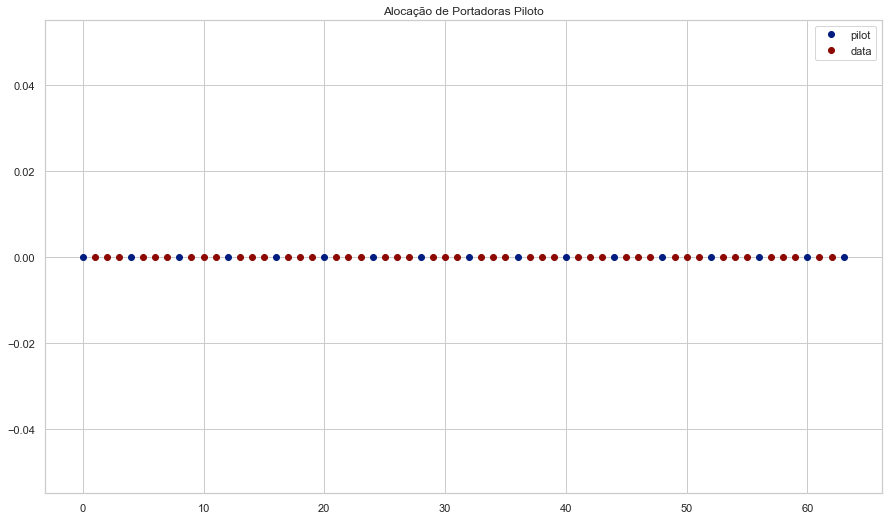

In [37]:
########### Distribuição das Portadoras

sns.set(style="whitegrid", palette="dark", color_codes=True)
graph_dims = (15.0, 8.7)
fig, plot = plt.subplots(figsize=graph_dims)
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')
plt.legend()
plt.title('Alocação de Portadoras Piloto')
plt.grid(True)
plt.show

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

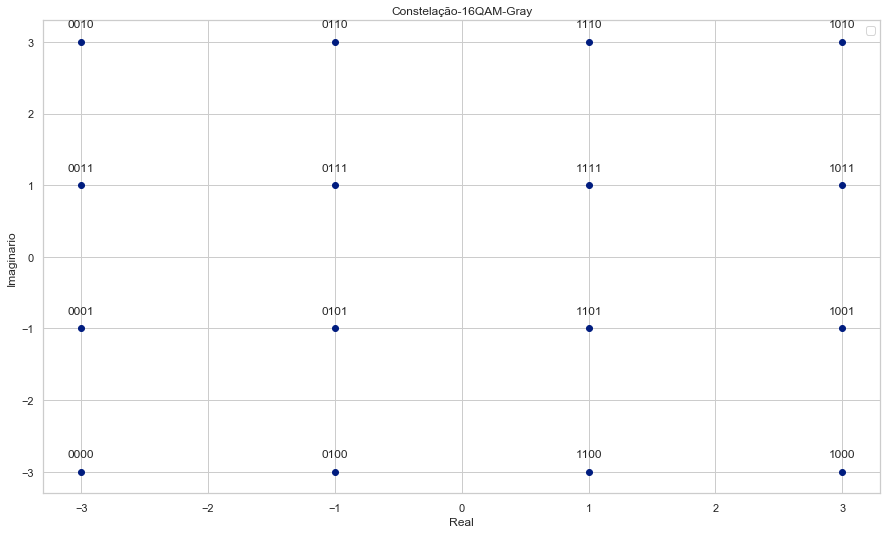

In [20]:
########################### Constelação 16 QAM ########################

mu = 4 # bits per symbol (i.e. 16QAM)
payloadBits_per_OFDM = len(dataCarriers)*mu  # number of payload bits per OFDM symbol

mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}

sns.set(style="whitegrid", palette="dark", color_codes=True)
graph_dims = (15.0, 8.7)
fig, plot = plt.subplots(figsize=graph_dims)
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]                
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

plt.legend()
plt.title('Constelação-16QAM-Gray')
plt.xlabel('Real')
plt.ylabel('Imaginario')
plt.grid(True)
plt.show

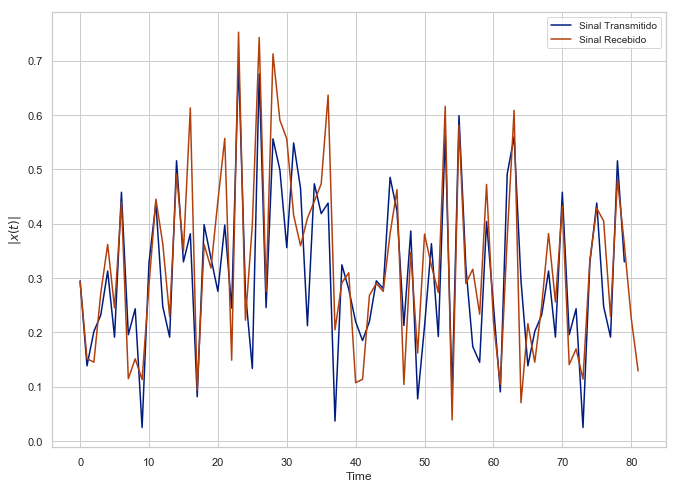

In [24]:
################### Sinal Transmitido vs Sinal Recebido para SNR de 25 dB ######################

SNRdB = 25
mod_choice = '16qam'
mu,modulator = mod_param(mod_choice) 
payloadBits_per_OFDM = len(dataCarriers)*mu
H_exact = np.fft.fft(channelResponse, K)
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
MOD = SP_Mapping(bits,modulator) ##### Apply SP_MOD###
OFDM_data = OFDM_symbol(MOD,pilotCarriers,dataCarriers,pilotValue) # Allocation of different subcarriers with data and pilots 

OFDM_time = IDFT(OFDM_data) # IDFT
OFDM_withCP = addCP(OFDM_time,CP) #### Add a cyclic prefix to the symbol
OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX,SNRdB,channelResponse)

OFDM_RX_noCP = removeCP(OFDM_RX,CP,K) ### Remove CP 
OFDM_demod = DFT(OFDM_RX_noCP) ## DFT
Hest = channelEstimate(OFDM_demod,pilotCarriers,pilotValue,allCarriers) ### Channel Estimative
equalized_Hest = equalize(OFDM_demod, Hest) ### Equalize Signal
MOD_est = get_payload(equalized_Hest,dataCarriers) ## Extracting the data carriers from the equalized symbol

bits_est = PS_Mapping(MOD_est,modulator) ## Demapping Symbols:

sns.set(style="whitegrid", palette="dark", color_codes=True)
graph_dims = (11.0, 8.0)
fig, plot = plt.subplots(figsize=graph_dims)
plt.plot(abs(OFDM_TX), label='Sinal Transmitido')
plt.plot(abs(OFDM_RX), label='Sinal Recebido')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$|x(t)|$');
plt.grid(True);

<function matplotlib.pyplot.show(*args, **kw)>

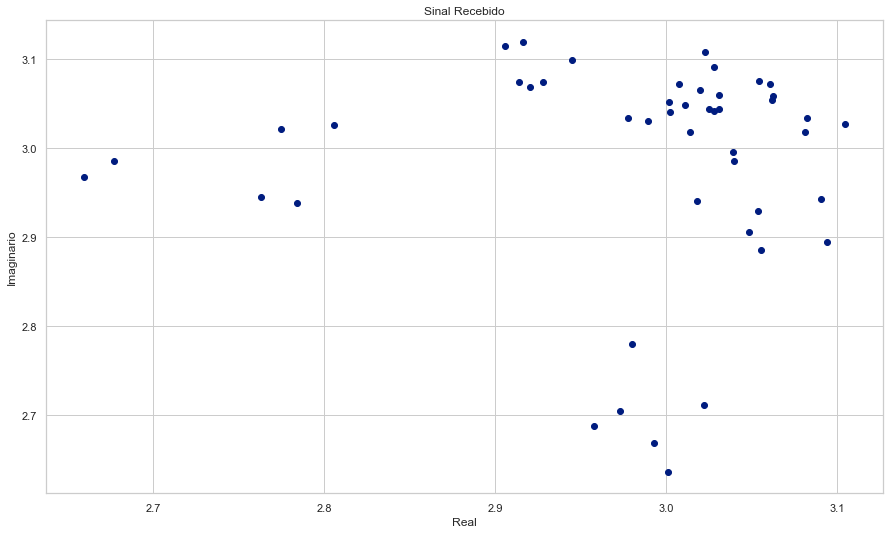

In [23]:
################# Constelação Sinal Recebido #########

sns.set(style="whitegrid", palette="dark", color_codes=True)
graph_dims = (15.0, 8.7)
fig, plot = plt.subplots(figsize=graph_dims)
plt.plot(MOD_est.real, MOD_est.imag, 'bo');
plt.title('Sinal Recebido')
plt.xlabel('Real')
plt.ylabel('Imaginario')
plt.grid(True)
plt.show

(0, 2)

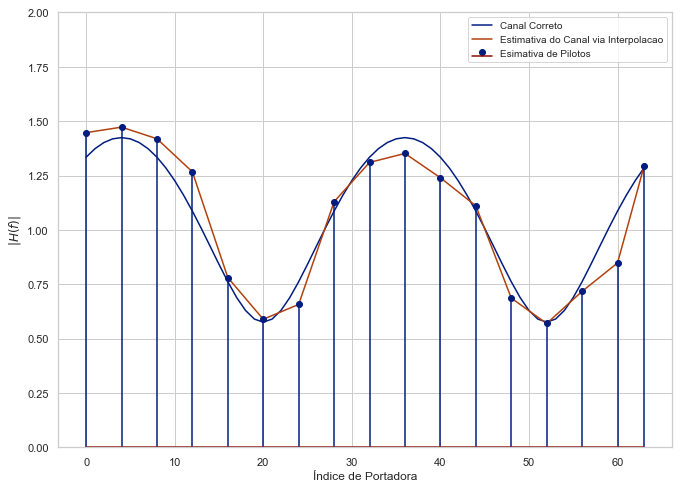

In [8]:
################## Plot da Estimativa do Canal ###########################

sns.set(style="whitegrid", palette="dark", color_codes=True)
graph_dims = (11.0, 8.0)
fig, plot = plt.subplots(figsize=graph_dims)

pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values

# Perform interpolation between the pilot carriers to get an estimate
# of the channel in the data carriers. Here, we interpolate absolute value and phase 
# separately
Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
Hest = Hest_abs * np.exp(1j*Hest_phase)

plt.plot(allCarriers, abs(H_exact), label='Canal Correto')
plt.plot(allCarriers, abs(Hest), label='Estimativa do Canal via Interpolacao')
plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Esimativa de Pilotos')
plt.grid(True); plt.xlabel('Índice de Portadora'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
plt.ylim(0,2)
    


<function matplotlib.pyplot.show(*args, **kw)>

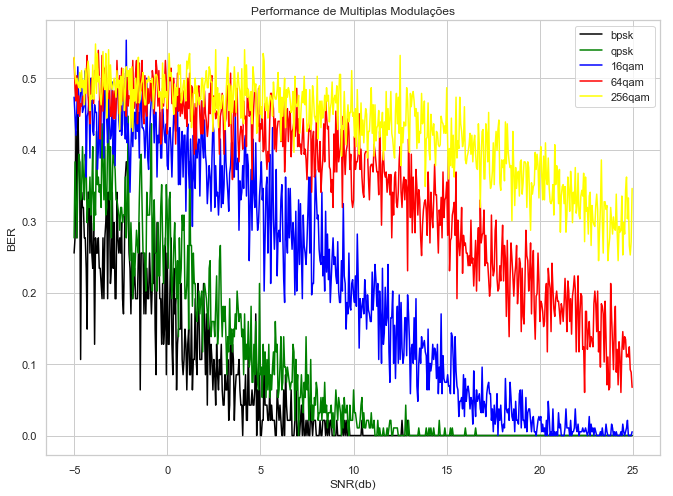

In [25]:
######################### Simulating Performance through multiple Modulations ###################

cols  = ['modulation','snr','ber']
mod_simulation = pd.DataFrame(data = None, columns = cols) 


for mod_choice in ['bpsk','qpsk','16qam','64qam','256qam']: 
    
       for SNRdB in np.arange(-5,25,0.05):

            mu,modulator = mod_param(mod_choice) 
            payloadBits_per_OFDM = len(dataCarriers)*mu
            H_exact = np.fft.fft(channelResponse, K)
            bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
            MOD = SP_Mapping(bits,modulator) ##### Apply SP_MOD###
            OFDM_data = OFDM_symbol(MOD,pilotCarriers,dataCarriers,pilotValue) # Allocation of different subcarriers with data and pilots 

            OFDM_time = IDFT(OFDM_data) # IDFT
            OFDM_withCP = addCP(OFDM_time,CP) #### Add a cyclic prefix to the symbol
            OFDM_TX = OFDM_withCP
            OFDM_RX = channel(OFDM_TX,SNRdB,channelResponse)

            OFDM_RX_noCP = removeCP(OFDM_RX,CP,K) ### Remove CP 
            OFDM_demod = DFT(OFDM_RX_noCP) ## DFT
            Hest = channelEstimate(OFDM_demod,pilotCarriers,pilotValue,allCarriers) ### Channel Estimative
            equalized_Hest = equalize(OFDM_demod, Hest) ### Equalize Signal
            MOD_est = get_payload(equalized_Hest,dataCarriers) ## Extracting the data carriers from the equalized symbol

            bits_est = PS_Mapping(MOD_est,modulator) ## Demapping Symbols:

            ber =  np.sum(abs(bits-bits_est))/len(bits)
            result = {'modulation':[mod_choice],
                       'snr':[SNRdB],
                       'ber':[ber]
                       }
            df_result =  pd.DataFrame(result) 
            mod_simulation = mod_simulation.append(df_result)
        
        

############### Print Simulation Results ############

sns.set(style="whitegrid", palette="dark", color_codes=True)
graph_dims = (11.0, 8.0)
fig, plot = plt.subplots(figsize=graph_dims)
plt.plot( 'snr', 'ber', data=mod_simulation.loc[mod_simulation['modulation']=='bpsk'],color = 'black', label = 'bpsk')
plt.plot( 'snr', 'ber', data=mod_simulation.loc[mod_simulation['modulation']=='qpsk'],color = 'green', label = 'qpsk')
plt.plot( 'snr', 'ber', data=mod_simulation.loc[mod_simulation['modulation']=='16qam'],color = 'blue', label = '16qam')
plt.plot( 'snr', 'ber', data=mod_simulation.loc[mod_simulation['modulation']=='64qam'],color = 'red', label = '64qam')
plt.plot( 'snr', 'ber', data=mod_simulation.loc[mod_simulation['modulation']=='256qam'],color = 'yellow', label = '256qam')
plt.legend()
plt.title('Performance de Multiplas Modulações')
plt.xlabel('SNR(db)')
plt.ylabel('BER')
plt.grid(True)
plt.show








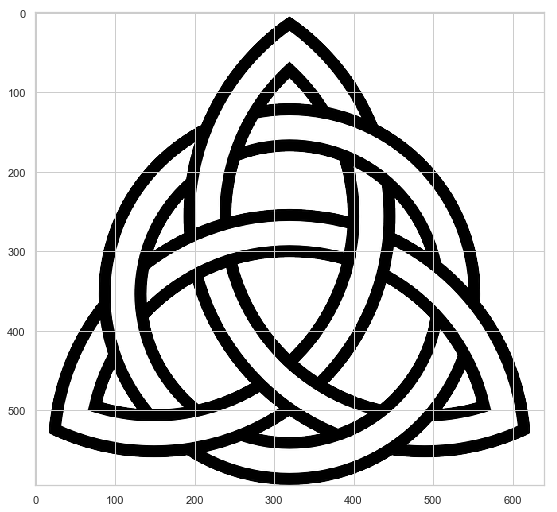

In [10]:
################### Aplicando Modulação à Imagem 

img =   Image.open('img_ofdm (1).bmp')
im2arr = np.array(img)
im2vect = im2arr.reshape((im2arr.shape[0]*im2arr.shape[1]*im2arr.shape[2],))
#reshaped_im2arr_ = im2vect.reshape(im2arr.shape[0],im2arr.shape[1],im2arr.shape[2])


########### Convert to bit vector ############
m = 8 ## Number of bits
bit_matrix = (((im2vect[:,None] & (1 << np.arange(m)))) > 0).astype(int)
bit_vect = bit_matrix.reshape((bit_matrix.shape[0]*bit_matrix.shape[1],))


sns.set(style="whitegrid", palette="dark", color_codes=True)
graph_dims = (15.0, 8.7)
fig, plot = plt.subplots(figsize=graph_dims)
imgplot = plt.imshow(im2arr)
plt.show()

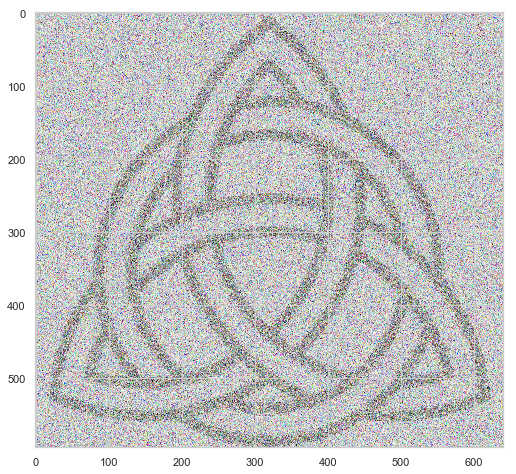

In [14]:
######################## Imagem com SNR de 1dB ##############################

SNRdB = 1
mod_choice = '16qam'
mu,modulator = mod_param(mod_choice) 
payloadBits_per_OFDM = len(dataCarriers)*mu
H_exact = np.fft.fft(channelResponse, K)
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
bit_num = math.floor(bit_vect.shape[0]/bits.shape[0])*bits.shape[0]

dim1 = bits.shape[0]
dim2 = math.floor(bit_vect[:bit_num].shape[0]/bits.shape[0])
input_sig = bit_vect[:bit_num].reshape(dim2,dim1)


for i in range(0,dim2):
    
    input_bits = input_sig[i]   

    MOD = SP_Mapping(input_bits,modulator) ##### Apply SP_MOD###
    OFDM_data = OFDM_symbol(MOD,pilotCarriers,dataCarriers,pilotValue) # Allocation of different subcarriers with data and pilots 

    OFDM_time = IDFT(OFDM_data) # IDFT
    OFDM_withCP = addCP(OFDM_time,CP) #### Add a cyclic prefix to the symbol
    OFDM_TX = OFDM_withCP
    OFDM_RX = channel(OFDM_TX,SNRdB,channelResponse)

    OFDM_RX_noCP = removeCP(OFDM_RX,CP,K) ### Remove CP 
    OFDM_demod = DFT(OFDM_RX_noCP) ## DFT
    Hest = channelEstimate(OFDM_demod,pilotCarriers,pilotValue,allCarriers) ### Channel Estimative
    equalized_Hest = equalize(OFDM_demod, Hest) ### Equalize Signal
    MOD_est = get_payload(equalized_Hest,dataCarriers) ## Extracting the data carriers from the equalized symbol
  
    bits_est = PS_Mapping(MOD_est,modulator) ## Demapping Symbols:
    
    if(i==0):
        bit_est_full = bits_est
    else:
        bit_est_full = np.row_stack((bit_est_full,bits_est))
        
reshape_out = bit_est_full.reshape(dim2*dim1)
reshape_out = np.concatenate([reshape_out,np.ones(bit_vect.shape[0]%bits.shape[0])])
reshape_out = reshape_out.reshape(bit_matrix.shape[0],8)

lst = list(itertools.product([0, 1], repeat=8))
lst.append((1,1,1,1,1,1,1,1))
num = list(range(0,256))
mapping = dict(zip(lst, num))


aux_arr = (reshape_out.copy()).astype(int)
out_img_vect  = np.array([mapping[(tuple(aux_arr[x]))] for x in range(0,aux_arr.shape[0])])
out_img = out_img_vect.reshape(im2arr.shape[0],im2arr.shape[1],im2arr.shape[2])

sns.set(style="whitegrid", palette="dark", color_codes=True)
graph_dims = (11.0, 8.0)
fig, plot = plt.subplots(figsize=graph_dims)
imgplot = plt.imshow(out_img)
plt.show()

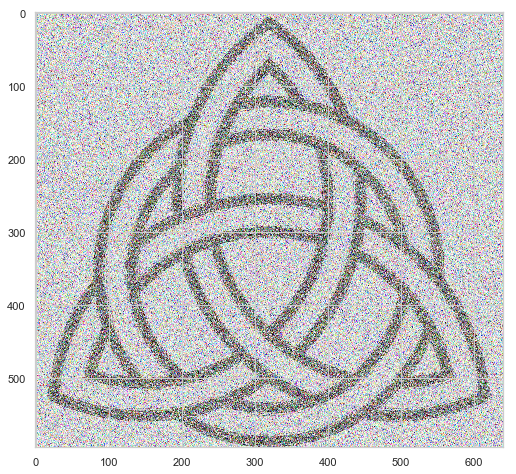

In [15]:
######################## Imagem com SNR de 5dB ##############################

SNRdB = 5
mod_choice = '16qam'
mu,modulator = mod_param(mod_choice) 
payloadBits_per_OFDM = len(dataCarriers)*mu
H_exact = np.fft.fft(channelResponse, K)
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
bit_num = math.floor(bit_vect.shape[0]/bits.shape[0])*bits.shape[0]

dim1 = bits.shape[0]
dim2 = math.floor(bit_vect[:bit_num].shape[0]/bits.shape[0])
input_sig = bit_vect[:bit_num].reshape(dim2,dim1)


for i in range(0,dim2):
    
    input_bits = input_sig[i]   

    MOD = SP_Mapping(input_bits,modulator) ##### Apply SP_MOD###
    OFDM_data = OFDM_symbol(MOD,pilotCarriers,dataCarriers,pilotValue) # Allocation of different subcarriers with data and pilots 

    OFDM_time = IDFT(OFDM_data) # IDFT
    OFDM_withCP = addCP(OFDM_time,CP) #### Add a cyclic prefix to the symbol
    OFDM_TX = OFDM_withCP
    OFDM_RX = channel(OFDM_TX,SNRdB,channelResponse)

    OFDM_RX_noCP = removeCP(OFDM_RX,CP,K) ### Remove CP 
    OFDM_demod = DFT(OFDM_RX_noCP) ## DFT
    Hest = channelEstimate(OFDM_demod,pilotCarriers,pilotValue,allCarriers) ### Channel Estimative
    equalized_Hest = equalize(OFDM_demod, Hest) ### Equalize Signal
    MOD_est = get_payload(equalized_Hest,dataCarriers) ## Extracting the data carriers from the equalized symbol
  
    bits_est = PS_Mapping(MOD_est,modulator) ## Demapping Symbols:
    
    if(i==0):
        bit_est_full = bits_est
    else:
        bit_est_full = np.row_stack((bit_est_full,bits_est))
        
reshape_out = bit_est_full.reshape(dim2*dim1)
reshape_out = np.concatenate([reshape_out,np.ones(bit_vect.shape[0]%bits.shape[0])])
reshape_out = reshape_out.reshape(bit_matrix.shape[0],8)

lst = list(itertools.product([0, 1], repeat=8))
lst.append((1,1,1,1,1,1,1,1))
num = list(range(0,256))
mapping = dict(zip(lst, num))


aux_arr = (reshape_out.copy()).astype(int)
out_img_vect  = np.array([mapping[(tuple(aux_arr[x]))] for x in range(0,aux_arr.shape[0])])
out_img = out_img_vect.reshape(im2arr.shape[0],im2arr.shape[1],im2arr.shape[2])

sns.set(style="whitegrid", palette="dark", color_codes=True)
graph_dims = (11.0, 8.0)
fig, plot = plt.subplots(figsize=graph_dims)
imgplot = plt.imshow(out_img)
plt.show()


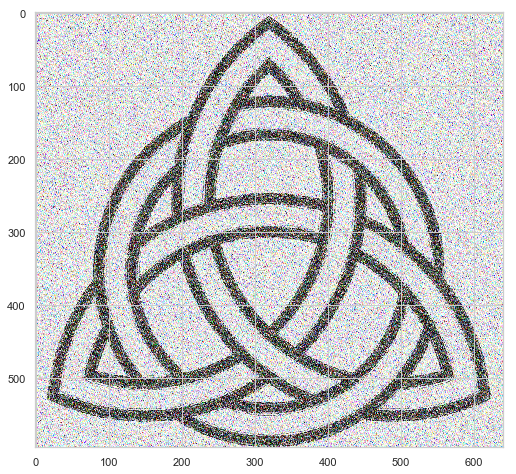

In [16]:
######################## Imagem com SNR de 10dB ##############################

SNRdB = 10
mod_choice = '16qam'
mu,modulator = mod_param(mod_choice) 
payloadBits_per_OFDM = len(dataCarriers)*mu
H_exact = np.fft.fft(channelResponse, K)
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
bit_num = math.floor(bit_vect.shape[0]/bits.shape[0])*bits.shape[0]

dim1 = bits.shape[0]
dim2 = math.floor(bit_vect[:bit_num].shape[0]/bits.shape[0])
input_sig = bit_vect[:bit_num].reshape(dim2,dim1)


for i in range(0,dim2):
    
    input_bits = input_sig[i]   

    MOD = SP_Mapping(input_bits,modulator) ##### Apply SP_MOD###
    OFDM_data = OFDM_symbol(MOD,pilotCarriers,dataCarriers,pilotValue) # Allocation of different subcarriers with data and pilots 

    OFDM_time = IDFT(OFDM_data) # IDFT
    OFDM_withCP = addCP(OFDM_time,CP) #### Add a cyclic prefix to the symbol
    OFDM_TX = OFDM_withCP
    OFDM_RX = channel(OFDM_TX,SNRdB,channelResponse)

    OFDM_RX_noCP = removeCP(OFDM_RX,CP,K) ### Remove CP 
    OFDM_demod = DFT(OFDM_RX_noCP) ## DFT
    Hest = channelEstimate(OFDM_demod,pilotCarriers,pilotValue,allCarriers) ### Channel Estimative
    equalized_Hest = equalize(OFDM_demod, Hest) ### Equalize Signal
    MOD_est = get_payload(equalized_Hest,dataCarriers) ## Extracting the data carriers from the equalized symbol
  
    bits_est = PS_Mapping(MOD_est,modulator) ## Demapping Symbols:
    
    if(i==0):
        bit_est_full = bits_est
    else:
        bit_est_full = np.row_stack((bit_est_full,bits_est))
        
reshape_out = bit_est_full.reshape(dim2*dim1)
reshape_out = np.concatenate([reshape_out,np.ones(bit_vect.shape[0]%bits.shape[0])])
reshape_out = reshape_out.reshape(bit_matrix.shape[0],8)

lst = list(itertools.product([0, 1], repeat=8))
lst.append((1,1,1,1,1,1,1,1))
num = list(range(0,256))
mapping = dict(zip(lst, num))


aux_arr = (reshape_out.copy()).astype(int)
out_img_vect  = np.array([mapping[(tuple(aux_arr[x]))] for x in range(0,aux_arr.shape[0])])
out_img = out_img_vect.reshape(im2arr.shape[0],im2arr.shape[1],im2arr.shape[2])

sns.set(style="whitegrid", palette="dark", color_codes=True)
graph_dims = (11.0, 8.0)
fig, plot = plt.subplots(figsize=graph_dims)
imgplot = plt.imshow(out_img)
plt.show()


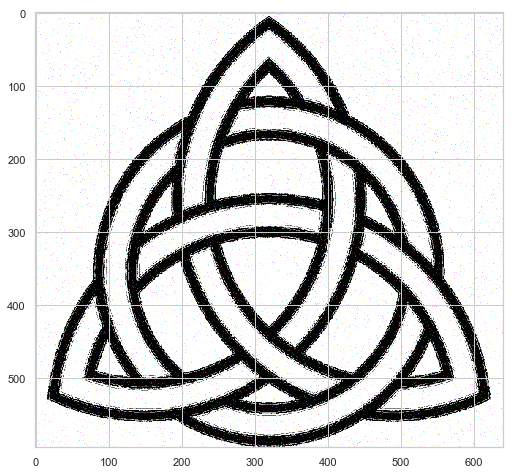

In [17]:
######################## Imagem com SNR de 25dB ##############################

SNRdB = 25
mod_choice = '16qam'
mu,modulator = mod_param(mod_choice) 
payloadBits_per_OFDM = len(dataCarriers)*mu
H_exact = np.fft.fft(channelResponse, K)
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
bit_num = math.floor(bit_vect.shape[0]/bits.shape[0])*bits.shape[0]

dim1 = bits.shape[0]
dim2 = math.floor(bit_vect[:bit_num].shape[0]/bits.shape[0])
input_sig = bit_vect[:bit_num].reshape(dim2,dim1)


for i in range(0,dim2):
    
    input_bits = input_sig[i]   

    MOD = SP_Mapping(input_bits,modulator) ##### Apply SP_MOD###
    OFDM_data = OFDM_symbol(MOD,pilotCarriers,dataCarriers,pilotValue) # Allocation of different subcarriers with data and pilots 

    OFDM_time = IDFT(OFDM_data) # IDFT
    OFDM_withCP = addCP(OFDM_time,CP) #### Add a cyclic prefix to the symbol
    OFDM_TX = OFDM_withCP
    OFDM_RX = channel(OFDM_TX,SNRdB,channelResponse)

    OFDM_RX_noCP = removeCP(OFDM_RX,CP,K) ### Remove CP 
    OFDM_demod = DFT(OFDM_RX_noCP) ## DFT
    Hest = channelEstimate(OFDM_demod,pilotCarriers,pilotValue,allCarriers) ### Channel Estimative
    equalized_Hest = equalize(OFDM_demod, Hest) ### Equalize Signal
    MOD_est = get_payload(equalized_Hest,dataCarriers) ## Extracting the data carriers from the equalized symbol
  
    bits_est = PS_Mapping(MOD_est,modulator) ## Demapping Symbols:
    
    if(i==0):
        bit_est_full = bits_est
    else:
        bit_est_full = np.row_stack((bit_est_full,bits_est))
        
reshape_out = bit_est_full.reshape(dim2*dim1)
reshape_out = np.concatenate([reshape_out,np.ones(bit_vect.shape[0]%bits.shape[0])])
reshape_out = reshape_out.reshape(bit_matrix.shape[0],8)

lst = list(itertools.product([0, 1], repeat=8))
lst.append((1,1,1,1,1,1,1,1))
num = list(range(0,256))
mapping = dict(zip(lst, num))


aux_arr = (reshape_out.copy()).astype(int)
out_img_vect  = np.array([mapping[(tuple(aux_arr[x]))] for x in range(0,aux_arr.shape[0])])
out_img = out_img_vect.reshape(im2arr.shape[0],im2arr.shape[1],im2arr.shape[2])

sns.set(style="whitegrid", palette="dark", color_codes=True)
graph_dims = (11.0, 8.0)
fig, plot = plt.subplots(figsize=graph_dims)
imgplot = plt.imshow(out_img)
plt.show()


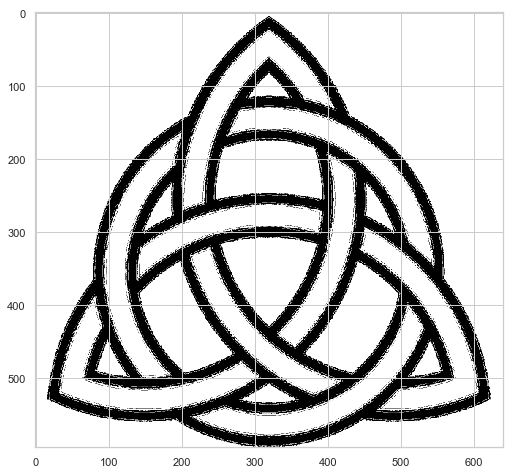

In [18]:
######################## Imagem com SNR de 50dB ##############################

SNRdB = 50
mod_choice = '16qam'
mu,modulator = mod_param(mod_choice) 
payloadBits_per_OFDM = len(dataCarriers)*mu
H_exact = np.fft.fft(channelResponse, K)
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
bit_num = math.floor(bit_vect.shape[0]/bits.shape[0])*bits.shape[0]

dim1 = bits.shape[0]
dim2 = math.floor(bit_vect[:bit_num].shape[0]/bits.shape[0])
input_sig = bit_vect[:bit_num].reshape(dim2,dim1)


for i in range(0,dim2):
    
    input_bits = input_sig[i]   

    MOD = SP_Mapping(input_bits,modulator) ##### Apply SP_MOD###
    OFDM_data = OFDM_symbol(MOD,pilotCarriers,dataCarriers,pilotValue) # Allocation of different subcarriers with data and pilots 

    OFDM_time = IDFT(OFDM_data) # IDFT
    OFDM_withCP = addCP(OFDM_time,CP) #### Add a cyclic prefix to the symbol
    OFDM_TX = OFDM_withCP
    OFDM_RX = channel(OFDM_TX,SNRdB,channelResponse)

    OFDM_RX_noCP = removeCP(OFDM_RX,CP,K) ### Remove CP 
    OFDM_demod = DFT(OFDM_RX_noCP) ## DFT
    Hest = channelEstimate(OFDM_demod,pilotCarriers,pilotValue,allCarriers) ### Channel Estimative
    equalized_Hest = equalize(OFDM_demod, Hest) ### Equalize Signal
    MOD_est = get_payload(equalized_Hest,dataCarriers) ## Extracting the data carriers from the equalized symbol
  
    bits_est = PS_Mapping(MOD_est,modulator) ## Demapping Symbols:
    
    if(i==0):
        bit_est_full = bits_est
    else:
        bit_est_full = np.row_stack((bit_est_full,bits_est))
        
reshape_out = bit_est_full.reshape(dim2*dim1)
reshape_out = np.concatenate([reshape_out,np.ones(bit_vect.shape[0]%bits.shape[0])])
reshape_out = reshape_out.reshape(bit_matrix.shape[0],8)

lst = list(itertools.product([0, 1], repeat=8))
lst.append((1,1,1,1,1,1,1,1))
num = list(range(0,256))
mapping = dict(zip(lst, num))


aux_arr = (reshape_out.copy()).astype(int)
out_img_vect  = np.array([mapping[(tuple(aux_arr[x]))] for x in range(0,aux_arr.shape[0])])
out_img = out_img_vect.reshape(im2arr.shape[0],im2arr.shape[1],im2arr.shape[2])

sns.set(style="whitegrid", palette="dark", color_codes=True)
graph_dims = (11.0, 8.0)
fig, plot = plt.subplots(figsize=graph_dims)
imgplot = plt.imshow(out_img)
plt.show()
